<a href="https://colab.research.google.com/github/extrajp2014/Water-Pump-Prediction/blob/master/Water_Pump_Failure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [0]:
!pip install category_encoders

    100% |████████████████████████████████| 61kB 3.8MB/s 


In [0]:
%matplotlib inline
import warnings
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.exceptions import DataConversionWarning
# data Process
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
# model setup
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
# metric
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score, roc_auc_score, confusion_matrix
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

# Google Colab Activation
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [0]:
def ini_preview(df):
#   print(df.head().T)
  print("-"*100)
  for i in df.columns:
    print(i)
#     print(df[i].value_counts().index.sort_values())  
    print(df[i].value_counts().sort_values(ascending=False))
    print("-"*100)

    
def submission(y_pred,X_test,outPath):
  id=pd.DataFrame(X_test.id,columns=['id']).astype('int32')
  prediction=pd.DataFrame(y_pred,columns=['status_group'])
  final=pd.concat([id, prediction], axis=1).to_csv(outPath, index=False, 
                                                   header=['id','status_group'])

# Preview Data

In [0]:
# train_features = pd.read_csv('train_features.csv')
# train_labels = pd.read_csv('train_labels.csv')
# test_features = pd.read_csv('test_features.csv')
# Google colab
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_features.csv')
sample_url = '/content/drive/My Drive/Colab Notebooks/sample_submission.csv'

num_features= ['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 
              'district_code', 'population', 'construction_year']
cat_features= ['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 
              'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 
              'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 
              'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 
              'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 
              'source_class', 'waterpoint_type', 'waterpoint_type_group']
# Features that seem to be important
select_features = ['funder', 'installer', 'basin', 'public_meeting', 'scheme_management', 'permit',
              'construction_year', 'extraction_type_class', 'payment_type', 'water_quality',
              'quantity', 'source_type', 'source_class', 'waterpoint_type',
             'waterpoint_type_group']

# Features that may not be important
drop_features=['date_recorded', 'wpt_name', 'subvillage', 'region', 'lga', 'ward', 
                 'recorded_by', 'scheme_name', 'extraction_type', 'extraction_type_group', 
                 'management', 'management_group', 'payment', 'quality_group', 
                 'quantity_group', 'source']

# 5 features with highest uniques values
drop_features=['date_recorded', 'wpt_name', 'subvillage', 'ward', 'scheme_name']

## Describe

In [0]:
print("test_features.shape:",test_features.shape)
print("-"*100)
print("unique values count for cat features")
print(test_features[cat_features].describe().iloc[1].sort_values(ascending=False))
test_features[cat_features].describe()
print("-"*100)
print("unique values count for num features")
print(test_features[num_features].describe().iloc[1].sort_values(ascending=False))

test_features.shape: (14358, 40)
----------------------------------------------------------------------------------------------------
unique values count for cat features
wpt_name                 10615
subvillage                8253
ward                      1934
scheme_name               1772
installer                 1075
funder                     960
date_recorded              331
lga                        124
region                      21
extraction_type             17
extraction_type_group       13
management                  12
scheme_management           11
source                      10
basin                        9
water_quality                8
payment                      7
extraction_type_class        7
waterpoint_type              7
source_type                  7
payment_type                 7
quality_group                6
waterpoint_type_group        6
quantity                     5
quantity_group               5
management_group             5
source_class           

## Value Counts

In [0]:
ini_preview(test_features[cat_features])

----------------------------------------------------------------------------------------------------
date_recorded
2011-03-16    137
2013-02-03    135
2011-03-17    135
2011-03-18    125
2011-03-14    125
2013-01-23    118
2011-03-15    118
2011-03-12    114
2013-01-30    111
2013-01-24    110
2013-02-04    110
2011-03-19    109
2013-01-29    109
2011-03-24    107
2013-03-19    105
2011-03-04    103
2011-03-09    102
2011-03-23    101
2013-02-18    100
2013-02-14    100
2013-01-18     98
2011-03-03     98
2011-03-08     95
2011-03-11     95
2011-07-27     94
2011-03-05     93
2013-03-13     93
2012-10-22     92
2011-03-22     91
2013-01-25     90
2011-02-26     89
2011-03-21     89
2011-03-10     89
2013-02-02     88
2011-07-16     88
2011-07-28     88
2011-03-06     87
2011-03-25     87
2013-02-01     87
2013-03-20     86
2013-02-09     86
2013-03-04     86
2011-03-13     86
2011-03-30     85
2013-02-19     85
2011-03-26     85
2011-07-20     85
2013-03-14     84
2011-02-23     84
201

Name: quality_group, dtype: int64
----------------------------------------------------------------------------------------------------
quantity
enough          7997
insufficient    3679
dry             1518
seasonal         982
unknown          182
Name: quantity, dtype: int64
----------------------------------------------------------------------------------------------------
quantity_group
enough          7997
insufficient    3679
dry             1518
seasonal         982
unknown          182
Name: quantity_group, dtype: int64
----------------------------------------------------------------------------------------------------
source
shallow well            4211
spring                  3974
machine dbh             2712
river                   2300
rainwater harvesting     515
hand dtw                 230
lake                     179
dam                      173
other                     44
unknown                   20
Name: source, dtype: int64
-----------------------------------------

In [0]:
ini_preview(test_features[num_features])

----------------------------------------------------------------------------------------------------
id
65536    1
59757    1
18441    1
34833    1
10261    1
14359    1
49176    1
53274    1
22555    1
57372    1
32       1
6211     1
67617    1
71715    1
10277    1
49192    1
24620    1
67633    1
49208    1
22587    1
26685    1
61502    1
63551    1
65600    1
4130     1
12582    1
24716    1
38915    1
2049     1
36930    1
47207    1
65616    1
67665    1
43093    1
14423    1
51289    1
20570    1
22619    1
59485    1
28766    1
51273    1
34913    1
51305    1
41028    1
4210     1
34799    1
10357    1
45174    1
47223    1
16504    1
32896    1
2177     1
36994    1
57665    1
45190    1
65680    1
73956    1
12518    1
57316    1
14487    1
18585    1
53402    1
61598    1
30879    1
32928    1
37026    1
47271    1
28894    1
32944    1
63679    1
73924    1
35148    1
51401    1
20682    1
57548    1
26829    1
208      1
7514     1
47319    1
20698    1
67761    1
61966

## Graph

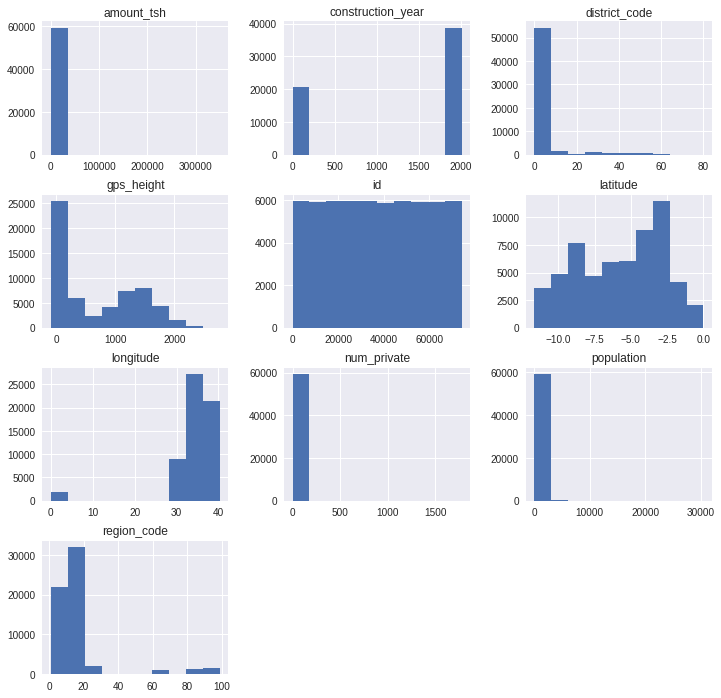

In [0]:
train_features.hist(figsize=(12,12))
plt.show();

# Baseline Model

## Test 0 - Validation Score:  0.6567451890784543

In [0]:
# mod:
'''
'selectkbest__k': range(4, len(X_train.columns)+1),
Only include numeric features
RobustScaler(),
SelectKBest(f_classif),
XGBClassifier()
'''
################################ 
submission_url = 'Model1-prediction-baseline0.csv'

# 0 Data Source
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test_features = pd.read_csv('test_features.csv')
# sample_submission = pd.read_csv('sample_submission.csv')

# 1 Set X & y - train & test
y_train = train_labels['status_group']
X_train = train_features
X_test  = test_features

# 2 Data Wrangle
X_train = X_train[list(X_train.select_dtypes(include=[np.number]))]
X_test = X_test[list(X_train.select_dtypes(include=[np.number]))]
print("X_train.shape:",X_train.shape)
print("X_test.shape:",X_test.shape)

# 3 Set X & y - train & validation from X & y train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 4 Make pipeline
pipeline = make_pipeline(
    RobustScaler(),
    SelectKBest(f_classif),
    XGBClassifier()
)
param_grid = {
    'selectkbest__k': range(4, len(X_train.columns)+1),
    'xgbclassifier__learning_rate': [0.2]
    }

# 5 Fit on the train set
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=2, 
                  scoring='accuracy', 
                  iid=False,
                  verbose=1)

gs.fit(X_train, y_train)

# 6 Validation Results
validation_score = gs.best_score_
print('Validation Score: ', validation_score)
print('Best parameter:', gs.best_params_)
print('Best estimator:', gs.best_estimator_)

# 7 Print which features was selected
selector = gs.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names=all_names[selected_mask]
unselected_names = all_names[~selected_mask]
print("-"*100)

print(all_names)
print("-"*100)
print('Features selected:')
for name in selected_names:
  print(name)
print("-"*100)

print("Features not selected:")
for name in unselected_names:
  print(name)
print("-"*100)

# 8 Make Prediction and Save submission
y_pred=gs.predict(X_test)
# for google colab
# submission_url = '/content/drive/My Drive/Colab Notebooks/Model1-prediction.csv'
submission(y_pred,test_features,submission_url)

print("train_labels.shape:",train_labels.shape)
print("submission csv shape:")
!cat Model1-prediction-baseline.csv | xargs -l echo | wc -l

X_train.shape: (59400, 10)
X_test.shape: (14358, 10)
(44550, 10) (14850, 10) (44550,) (14850,)
Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  1.2min finished


Validation Score:  0.6567451890784543
Best parameter: {'selectkbest__k': 8, 'xgbclassifier__learning_rate': 0.2}
Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=8, score_func=<function f_classif at 0x7f094c172bf8>)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 ...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])
----------------------------------------------------------------------------------------------------
Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Features selected:
amount_tsh
gps_height
longitude
l

## Test 0A - Validation Score:  0.6589674523007856

In [0]:
# mod:
'''
SelectKBest(f_classif), 30
Only include numeric features
PolynomialFeatures()
RobustScaler(),
SelectKBest(f_classif),
XGBClassifier()
'''
################################ 
submission_url = 'Model1-prediction-baseline0B.csv'

# 0 Data Source
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test_features = pd.read_csv('test_features.csv')
# sample_submission = pd.read_csv('sample_submission.csv')

# 1 Set X & y - train & test
y_train = train_labels['status_group']
X_train = train_features
X_test  = test_features

# 2 Data Wrangle
X_train = X_train[list(X_train.select_dtypes(include=[np.number]))]
X_test = X_test[list(X_train.select_dtypes(include=[np.number]))]
poly = PolynomialFeatures(3)
X_train = poly.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = poly.fit_transform(X_test)
X_test = pd.DataFrame(X_test)

print("X_test.shape:",X_test.shape)

# 3 Set X & y - train & validation from X & y train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 4 Make pipeline
pipeline = make_pipeline(
#     ce.OneHotEncoder(use_cat_names=True), 
    RobustScaler(),
    SelectKBest(f_classif),
    XGBClassifier()
)
param_grid = {
#     'selectkbest__k': range(7, len(X_train.columns)+1),
    'selectkbest__k': [200],
    'xgbclassifier__learning_rate': [0.2]
    }

# 5 Fit on the train set
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=2, 
                  scoring='accuracy', 
                  iid=False,
                  verbose=1)

gs.fit(X_train, y_train)

# 6 Validation Results
validation_score = gs.best_score_
print('Validation Score: ', validation_score)
print('Best parameter:', gs.best_params_)
print('Best estimator:', gs.best_estimator_)

# 7 Make Prediction and Save submission
y_pred=gs.predict(X_test)
# for google colab
# submission_url = '/content/drive/My Drive/Colab Notebooks/Model1-prediction.csv'
submission(y_pred,test_features,submission_url)

print("train_labels.shape:",train_labels.shape)
print("submission csv shape:")
!cat Model1-prediction-baseline.csv | xargs -l echo | wc -l


X_test.shape: (14358, 286)
(44550, 286) (14850, 286) (44550,) (14850,)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min finished


Validation Score:  0.6589674523007856
Best parameter: {'selectkbest__k': 200, 'xgbclassifier__learning_rate': 0.2}
Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=200, score_func=<function f_classif at 0x7f094c172bf8>)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])
RangeIndex(start=0, stop=286, step=1)
----------------------------------------------------------------------------------------------------
Features selected:
2
3
4
5
7
8
9
10
12
13
14
15
17
18
20
22
23
24
26
27
28
29
30
31
32
35
36
37
38
39
41
42
43
44
45
47
48
49
50
56
57
58
59
60
61
62
63
64
65
67
68
69
70
72
73
75
77
78
79
81
82
83
84
85
86
87
88
90
91
92
93
94
96
97
98
99
100
102
103
105
110
111
112
113
114
115
116
117
119
120
12

## Test 0B - Validation Score:  0.6598204264870932

In [0]:
# mod:
'''
SelectKBest(f_classif), 250
Only include numeric features
PolynomialFeatures()
StandardScaler(),
SelectKBest(f_classif),
XGBClassifier()
'''
################################ 
submission_url = 'Model1-prediction-baseline0B.csv'

# 0 Data Source
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test_features = pd.read_csv('test_features.csv')
# sample_submission = pd.read_csv('sample_submission.csv')

# 1 Set X & y - train & test
y_train = train_labels['status_group']
X_train = train_features
X_test  = test_features

# 2 Data Wrangle
X_train = X_train[list(X_train.select_dtypes(include=[np.number]))]
X_test = X_test[list(X_train.select_dtypes(include=[np.number]))]

print("Before - X_test.shape:",X_test.shape)
poly = PolynomialFeatures(3)
X_train = poly.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = poly.fit_transform(X_test)
X_test = pd.DataFrame(X_test)

print("After - X_test.shape:",X_test.shape)

# 3 Set X & y - train & validation from X & y train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 4 Make pipeline
pipeline = make_pipeline(
#     ce.OneHotEncoder(use_cat_names=True), 
    RobustScaler(),
    SelectKBest(f_classif),
    XGBClassifier()
)
param_grid = {
#     'selectkbest__k': range(7, len(X_train.columns)+1),
    'selectkbest__k': [250],
    'xgbclassifier__learning_rate': [0.2]
    }

# 5 Fit on the train set
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=2, 
                  scoring='accuracy', 
                  iid=False,
                  verbose=1)

gs.fit(X_train, y_train)

# 6 Validation Results
validation_score = gs.best_score_
print('Validation Score: ', validation_score)
print('Best parameter:', gs.best_params_)
print('Best estimator:', gs.best_estimator_)

# 7 Make Prediction and Save submission
y_pred=gs.predict(X_test)
# for google colab
# submission_url = '/content/drive/My Drive/Colab Notebooks/Model1-prediction.csv'
submission(y_pred,test_features,submission_url)

print("train_labels.shape:",train_labels.shape)
print("submission csv shape:")
!cat Model1-prediction-baseline.csv | xargs -l echo | wc -l


X_test.shape: (14358, 286)
(44550, 286) (14850, 286) (44550,) (14850,)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.0min finished


Validation Score:  0.6598204264870932
Best parameter: {'selectkbest__k': 250, 'xgbclassifier__learning_rate': 0.2}
Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=250, score_func=<function f_classif at 0x7f094c172bf8>)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])
train_labels.shape: (59400, 2)
submission csv shape:
14359


# Select Best Features + Onehotencoder model

## Test 1- Validation Score:  0.7488885911090224

In [0]:
# mod:
'''
Drop 12 cat features
SelectKBest(f_classif), 60
ce.OneHotEncoder(use_cat_names=True)
StandardScaler(),
SelectKBest(f_classif),
XGBClassifier()
'''
################################ 
# submission_url = 'Model1-prediction-Onehotencoder.csv'
submission_url = '/content/drive/My Drive/Colab Notebooks/Model_OneHotEncoder00.csv'

# 0 Data Source
################################ 
# Google colab
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_features.csv')
sample_url = '/content/drive/My Drive/Colab Notebooks/sample_submission.csv'

# Local
# train_features = pd.read_csv('train_features.csv')
# train_labels = pd.read_csv('train_labels.csv')
# test_features = pd.read_csv('test_features.csv')
# sample_submission = pd.read_csv('sample_submission.csv')

# 1 Set X & y - train & test
y_train = train_labels['status_group']
X_train = train_features
X_test  = test_features
print("Before - X_test.shape:",X_test.shape)

# 2 Data Wrangle
################################ 
# X_train = X_train.replace({True: 1, False: 0})
# X_test = X_test.replace({True: 1, False: 0})
X_train = X_train.replace({np.nan: 'unknown'})
X_test = X_test.replace({np.nan: 'unknown'})

drop_features=['date_recorded', 'wpt_name', 'subvillage', 'region', 'lga', 'ward', 
                 'recorded_by', 'scheme_name', 'extraction_type', 'extraction_type_group', 
                 'management', 'management_group', 'payment', 'quality_group', 
                 'quantity_group', 'source']
X_train = X_train.drop(columns=drop_features)
X_test = X_test.drop(columns=drop_features)

print("After - X_test.shape:",X_test.shape)

# 3 Set X & y - train & validation from X & y train
################################ 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 4 Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    SelectKBest(f_classif),
    XGBClassifier()
)
param_grid = {
#     'selectkbest__k': range(7, len(X_train.columns)+1),
    'selectkbest__k': [60],
    'xgbclassifier__learning_rate': [0.2]
    }

# 5 Fit on the train set
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=2, 
                  scoring='accuracy', 
                  iid=False,
                  verbose=1)

gs.fit(X_train, y_train)

# 6 Validation Results
validation_score = gs.best_score_
print('Validation Score: ', validation_score)
print('Best parameter:', gs.best_params_)
print('Best estimator:', gs.best_estimator_)

# 7 Make Prediction and Save submission
y_pred=gs.predict(X_test)
# for google colab

submission(y_pred,test_features,submission_url)

print("train_labels.shape:",train_labels.shape)
print("submission csv shape:")
!cat Model1-prediction-baseline.csv | xargs -l echo | wc -l


Before - X_test.shape: (14358, 40)
After - X_test.shape: (14358, 24)
(44550, 24) (14850, 24) (44550,) (14850,)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min finished


Validation Score:  0.7488885911090224
Best parameter: {'selectkbest__k': 60, 'xgbclassifier__learning_rate': 0.2}
Best estimator: Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['funder', 'installer', 'basin', 'public_meeting', 'scheme_management', 'permit', 'extraction_type_class', 'payment_type', 'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group'],
       drop_invariant=False,...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])


NameError: ignored

## Test 2 - Validation Score:  0.7562289562289561

In [0]:
# mod:
'''
Drop 12 cat features
SelectKBest(f_classif), 1000
ce.OneHotEncoder(use_cat_names=True)
StandardScaler(),
SelectKBest(f_classif),
XGBClassifier()
'''
################################ 

submission_url = '/content/drive/My Drive/Colab Notebooks/Model_OneHotEncoder02.csv'

# 0 Data Source
################################ 
# Google colab
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_features.csv')
sample_url = '/content/drive/My Drive/Colab Notebooks/sample_submission.csv'

# Local
# train_features = pd.read_csv('train_features.csv')
# train_labels = pd.read_csv('train_labels.csv')
# test_features = pd.read_csv('test_features.csv')
# sample_submission = pd.read_csv('sample_submission.csv')

# 1 Set X & y - train & test
y_train = train_labels['status_group']
X_train = train_features
X_test  = test_features
print("Before - X_test.shape:",X_test.shape)

# 2 Data Wrangle
################################ 
# X_train = X_train.replace({True: 1, False: 0})
# X_test = X_test.replace({True: 1, False: 0})
X_train = X_train.replace({np.nan: 'unknown'})
X_test = X_test.replace({np.nan: 'unknown'})

# dummy_cols = ['funder', 'installer', 'basin', 'public_meeting', 'scheme_management', 'permit',
#               'construction_year', 'extraction_type_class', 'payment_type', 'water_quality',
#               'quantity', 'source_type', 'source_class', 'waterpoint_type',
#              'waterpoint_type_group']
# X_train = pd.get_dummies(X_train, columns = dummy_cols)
# X_train = X_train.sample(frac=1).reset_index(drop=True)
# X_test = pd.get_dummies(X_test, columns = dummy_cols)

drop_features=['date_recorded', 'wpt_name', 'subvillage', 'region', 'lga', 'ward', 
                 'recorded_by', 'scheme_name', 'extraction_type', 'extraction_type_group', 
                 'management', 'management_group', 'payment', 'quality_group', 
                 'quantity_group', 'source']
X_train = X_train.drop(columns=drop_features)
X_test = X_test.drop(columns=drop_features)

print("After - X_test.shape:",X_test.shape)

# 3 Set X & y - train & validation from X & y train
################################ 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 4 Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    SelectKBest(f_classif),
    XGBClassifier()
)
param_grid = {
#     'selectkbest__k': range(7, len(X_train.columns)+1),
    'selectkbest__k': [1000],
    'xgbclassifier__learning_rate': [0.2]
    }

# 5 Fit on the train set
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=2, 
                  scoring='accuracy', 
                  iid=False,
                  verbose=1)

gs.fit(X_train, y_train)

# 6 Validation Results
validation_score = gs.best_score_
print('Validation Score: ', validation_score)
print('Best parameter:', gs.best_params_)
print('Best estimator:', gs.best_estimator_)

# 7 Make Prediction and Save submission
y_pred=gs.predict(X_test)
# for google colab

submission(y_pred,test_features,submission_url)

print("train_labels.shape:",train_labels.shape)
print("submission csv shape:")

Before - X_test.shape: (14358, 40)
After - X_test.shape: (14358, 24)
(44550, 24) (14850, 24) (44550,) (14850,)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.8min finished


Validation Score:  0.7562289562289561
Best parameter: {'selectkbest__k': 1000, 'xgbclassifier__learning_rate': 0.2}
Best estimator: Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['funder', 'installer', 'basin', 'public_meeting', 'scheme_management', 'permit', 'extraction_type_class', 'payment_type', 'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group'],
       drop_invariant=False,...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])
train_labels.shape: (59400, 2)
submission csv shape:
cat: Model1-prediction-baseline.csv: No such file or directory
1


## Test 3- Validation Score:  0.7576879431707029

In [0]:
# mod:
'''
Drop 12 cat features
SelectKBest(f_classif), 2000, Max
ce.OneHotEncoder(use_cat_names=True)
StandardScaler(),
SelectKBest(f_classif),
XGBClassifier()
'''
################################ 
# submission_url = 'Model1-prediction-Onehotencoder.csv'
submission_url = '/content/drive/My Drive/Colab Notebooks/Model_OneHotEncoder03.csv'

# 0 Data Source
################################ 
# Google colab
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_features.csv')
sample_url = '/content/drive/My Drive/Colab Notebooks/sample_submission.csv'

# Local
# train_features = pd.read_csv('train_features.csv')
# train_labels = pd.read_csv('train_labels.csv')
# test_features = pd.read_csv('test_features.csv')
# sample_submission = pd.read_csv('sample_submission.csv')

# 1 Set X & y - train & test
y_train = train_labels['status_group']
X_train = train_features
X_test  = test_features
print("Before - X_test.shape:",X_test.shape)

# 2 Data Wrangle
################################ 
# X_train = X_train.replace({True: 1, False: 0})
# X_test = X_test.replace({True: 1, False: 0})
X_train = X_train.replace({np.nan: 'unknown'})
X_test = X_test.replace({np.nan: 'unknown'})

drop_features=['date_recorded', 'wpt_name', 'subvillage', 'region', 'lga', 'ward', 
                 'recorded_by', 'scheme_name', 'extraction_type', 'extraction_type_group', 
                 'management', 'management_group', 'payment', 'quality_group', 
                 'quantity_group', 'source']
X_train = X_train.drop(columns=drop_features)
X_test = X_test.drop(columns=drop_features)

print("After - X_test.shape:",X_test.shape)

# 3 Set X & y - train & validation from X & y train
################################ 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 4 Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    SelectKBest(f_classif),
    XGBClassifier()
)
param_grid = {
    'selectkbest__k': [2000, len(X_train.columns)],
    'xgbclassifier__learning_rate': [0.2]
    }

# 5 Fit on the train set
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=2, 
                  scoring='accuracy', 
                  iid=False,
                  verbose=1)

gs.fit(X_train, y_train)

# 6 Validation Results
validation_score = gs.best_score_
print('Validation Score: ', validation_score)
print('Best parameter:', gs.best_params_)
print('Best estimator:', gs.best_estimator_)

# 7 Make Prediction and Save submission
y_pred=gs.predict(X_test)
# for google colab

submission(y_pred,test_features,submission_url)

print("test_features.shape:",test_features.shape)
print("submission csv shape:")

Before - X_test.shape: (14358, 40)
After - X_test.shape: (14358, 24)
(44550, 24) (14850, 24) (44550,) (14850,)
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 24.5min finished


Validation Score:  0.7576879431707029
Best parameter: {'selectkbest__k': 2000, 'xgbclassifier__learning_rate': 0.2}
Best estimator: Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['funder', 'installer', 'basin', 'public_meeting', 'scheme_management', 'permit', 'extraction_type_class', 'payment_type', 'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group'],
       drop_invariant=False,...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])
train_labels.shape: (59400, 2)
submission csv shape:


In [0]:
## Test 3 - Validation Score:  0.7588776655443322

In [0]:
# mod:
'''
Drop 12 cat features
SelectKBest(f_classif), 2000, Max
ce.OneHotEncoder(use_cat_names=True)
StandardScaler(),
SelectKBest(f_classif),
XGBClassifier()
'''
################################ 

# Local
# submission_url = 'Model_OneHotEncoder03.csv'
# Google colab
submission_url = '/content/drive/My Drive/Colab Notebooks/Model_OneHotEncoder03.csv'

# 0 Data Source
################################ 
# Google colab
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_features.csv')
sample_url = '/content/drive/My Drive/Colab Notebooks/sample_submission.csv'

# Local
# train_features = pd.read_csv('train_features.csv')
# train_labels = pd.read_csv('train_labels.csv')
# test_features = pd.read_csv('test_features.csv')
# sample_submission = pd.read_csv('sample_submission.csv')

# 1 Set X & y - train & test
y_train = train_labels['status_group']
X_train = train_features
X_test  = test_features
print("Before - X_test.shape:",X_test.shape)

# 2 Data Wrangle
################################ 
# X_train = X_train.replace({True: 1, False: 0})
# X_test = X_test.replace({True: 1, False: 0})
X_train = X_train.replace({np.nan: 'unknown'})
X_test = X_test.replace({np.nan: 'unknown'})

# Top 5 features with high uniques values
drop_features=['date_recorded', 'wpt_name', 'subvillage', 'ward', 'scheme_name']
X_train = X_train.drop(columns=drop_features)
X_test = X_test.drop(columns=drop_features)

print("After - X_test.shape:",X_test.shape)
X_test.head()

# 3 Set X & y - train & validation from X & y train
################################ 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 4 Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    SelectKBest(f_classif),
    XGBClassifier()
)
param_grid = {
    'selectkbest__k': [1000],
    'xgbclassifier__learning_rate': [0.2]
    }

# 5 Fit on the train set
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=2, 
                  scoring='accuracy', 
                  iid=False,
                  verbose=1)

gs.fit(X_train, y_train)

# 6 Cross-Validation Results
validation_score = gs.best_score_
print('Validation Score: ', validation_score)
print('Best parameter:', gs.best_params_)
print('Best estimator:', gs.best_estimator_)

# 7 Make Prediction and Save submission
y_pred=gs.predict(X_test)
# for google colab

submission(y_pred,test_features,submission_url)

print("test_features.shape:",test_features.shape)

Before - X_test.shape: (14358, 40)
After - X_test.shape: (14358, 35)
(44550, 35) (14850, 35) (44550,) (14850,)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.0min finished


Validation Score:  0.7588776655443322
Best parameter: {'selectkbest__k': 1000, 'xgbclassifier__learning_rate': 0.2}
Best estimator: Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['funder', 'installer', 'basin', 'region', 'lga', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quali...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])
test_features.shape: (14358, 40)
submission csv shape:


## Test 4 - Validation Score:  0.7855638699451797

In [0]:
# mod:
'''
Drop 5 feature with highest uniques
SelectKBest(f_classif), 2000
ce.OneHotEncoder(use_cat_names=True)
RobustScaler(),
SelectKBest(f_classif),
XGBClassifier() - learning_rate = 0.1
'''
################################ 

# Local
# submission_url = 'Model_OneHotEncoder04.csv'
# Google colab
submission_url = '/content/drive/My Drive/Colab Notebooks/Model_OneHotEncoder04.csv'

# 0 Data Source
################################ 
# Google colab
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_features.csv')
sample_url = '/content/drive/My Drive/Colab Notebooks/sample_submission.csv'

# Local
# train_features = pd.read_csv('train_features.csv')
# train_labels = pd.read_csv('train_labels.csv')
# test_features = pd.read_csv('test_features.csv')
# sample_submission = pd.read_csv('sample_submission.csv')

# 1 Set X & y - train & test
y_train = train_labels['status_group']
X_train = train_features
X_test  = test_features
print("Before - X_test.shape:",X_test.shape)

# 2 Data Wrangle
################################ 

X_train = X_train.replace({np.nan: 'unknown'})
X_test = X_test.replace({np.nan: 'unknown'})

# Top 5 features with high uniques values
# Drop longitude and latitude - maybe not useful
drop_features=['date_recorded', 'wpt_name', 'subvillage', 'ward', 'scheme_name', 'longitude', 'latitude']
X_train = X_train.drop(columns=drop_features)
X_test = X_test.drop(columns=drop_features)

print("After - X_test.shape:",X_test.shape)
X_test.head()

# 3 Set X & y - train & validation from X & y train
################################ 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 4 Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    RobustScaler(),
    SelectKBest(f_classif),
    XGBClassifier(booster='gbtree', objective ='multi:softmax', num_class=3, 
                 eval_metric='merror',eta=.2, max_depth=8)
)
param_grid = {
    'selectkbest__k': [2000],
    'xgbclassifier__learning_rate': [0.2],
}

# 5 Fit on the train set
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=2, 
                  scoring='accuracy', 
                  iid=False,
                  verbose=1)

gs.fit(X_train, y_train)

# 6 Validation Results
validation_score = gs.best_score_
print('Validation Score: ', validation_score)
print('Best parameter:', gs.best_params_)
print('Best estimator:', gs.best_estimator_)

# 7 Make Prediction and Save submission
y_pred=gs.predict(X_test)
# for google colab

submission(y_pred,test_features,submission_url)

print("test_features.shape:",test_features.shape)

Before - X_test.shape: (14358, 40)
After - X_test.shape: (14358, 33)
(47520, 33) (11880, 33) (47520,) (11880,)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 36.6min finished


Validation Score:  0.7855638699451797
Best parameter: {'selectkbest__k': 2000, 'xgbclassifier__learning_rate': 0.2}
Best estimator: Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['funder', 'installer', 'basin', 'region', 'lga', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quali...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])
test_features.shape: (14358, 40)


## Test 5 - Validation Score:  0.7941919191919192

In [0]:
# mod:
'''
drop nonsignificant features
ce.OneHotEncoder(use_cat_names=True)
XGBClassifier() - learning_rate = 0.2
'''
################################ 

# Local
# submission_url = 'Model_OneHotEncoder05.csv'
# Google colab
submission_url = '/content/drive/My Drive/Colab Notebooks/Model_OneHotEncoder05.csv'

# 0 Data Source
################################ 
# Google colab
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_features.csv')
sample_url = '/content/drive/My Drive/Colab Notebooks/sample_submission.csv'

# Local
# train_features = pd.read_csv('train_features.csv')
# train_labels = pd.read_csv('train_labels.csv')
# test_features = pd.read_csv('test_features.csv')
# sample_submission = pd.read_csv('sample_submission.csv')

# 1 Set X & y - train & test
y_train = train_labels['status_group']
X_train = train_features
X_test  = test_features
print("Before - X_test.shape:",X_test.shape)

# 2 Data Wrangle
################################ 

X_train = X_train.replace({np.nan: 'unknown'})
X_test = X_test.replace({np.nan: 'unknown'})

# Features that may not be important
drop_features=['date_recorded', 'wpt_name', 'subvillage', 'region_code', 'construction_year',
               'subvillage', 'ward', 'public_meeting', 'recorded_by', 'scheme_name', 
               'extraction_type', 'extraction_type_group', 'extraction_type_class',
               'management_group', 'payment', 'quality_group', 'quantity_group', 'source_type', 
               'source_class','waterpoint_type_group','installer']
X_train = X_train.drop(columns=drop_features)
X_test = X_test.drop(columns=drop_features)

print("After - X_test.shape:",X_test.shape)
X_test.head()

# 4 Make pipeline
model = ce.OneHotEncoder()
model.fit(X_train,y_train)
X_train = model.transform(X_train)
X_test = model.transform(X_test)
print("After - X_test.shape:",X_test.shape)

# 3 Set X & y - train & validation from X & y train
################################ 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

model = XGBClassifier(booster='gbtree', objective ='multi:softmax', num_class=3, 
                    eta=.2, max_depth=8, n_estimators=1000, learning_rate=0.2)

model.fit(X_train, y_train, eval_metric='merror', early_stopping_rounds=50, 
        eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)
y_pred = model.predict(X_val)

# 6 Validation Results
print('Validation Score: ', accuracy_score(y_val,y_pred))

# 7 Make Prediction and Save submission
y_pred=model.predict(X_test)
submission(y_pred,test_features,submission_url)

Before - X_test.shape: (14358, 40)
After - X_test.shape: (14358, 20)
After - X_test.shape: (14358, 2138)
(47520, 2138) (11880, 2138) (47520,) (11880,)
[0]	validation_0-merror:0.251347	validation_1-merror:0.261448
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.2496	validation_1-merror:0.259596
[2]	validation_0-merror:0.247685	validation_1-merror:0.259343
[3]	validation_0-merror:0.246212	validation_1-merror:0.25867
[4]	validation_0-merror:0.240636	validation_1-merror:0.25303
[5]	validation_0-merror:0.236848	validation_1-merror:0.250084
[6]	validation_0-merror:0.237647	validation_1-merror:0.250337
[7]	validation_0-merror:0.235838	validation_1-merror:0.248316
[8]	validation_0-merror:0.235227	validation_1-merror:0.248737
[9]	validation_0-merror:0.232807	validation_1-merror:0.246549
[10]	validation_0-merror:0.232386	validation_1-merror:0.246717
[11]	va

NameError: ignored

#LabelEncoder Model

## Test 1 - Validation Score:  0.8101010101010101

In [0]:
# mod:
'''
Add extra features, no drop
LabelEncoder
PolynominalFeatures()
StandardScaler()
XGBClassifier() - learning_rate = 0.2
'''
################################ 

# Local
# submission_url = 'Model_LabelEncoder01.csv'
# Google colab
submission_url = '/content/drive/My Drive/Colab Notebooks/Model_LabelEncoder01.csv'

# 0 Data Source
################################ 
# Local
# train_features = pd.read_csv('train_features.csv')
# train_labels = pd.read_csv('train_labels.csv')
# test_features = pd.read_csv('test_features.csv')
# # sample_submission = pd.read_csv('sample_submission.csv')

# Google colab
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_features.csv')
sample_url = '/content/drive/My Drive/Colab Notebooks/sample_submission.csv'

# 1 Set X & y - train & test
y_train = train_labels['status_group']
X_train = train_features
X_test  = test_features
print("Before - X_test.shape:",X_test.shape)
print("Before - X_train.shape:",X_train.shape)

################################ 
# 2 Data Wrangle
################################ 

def wrangle(df):
    for i in df.select_dtypes(exclude=[np.number]).columns:
      df[i] = df[i].str.lower()
    df['gps_height'].replace(0.0, 1300, inplace=True)
    df['longitude'].replace(0.0, 35, inplace=True)
    df['construction_year'].replace(0.0, 1995, inplace=True)
    df['date_recorded'] = pd.to_datetime(df.date_recorded)
    df['years_service'] = df.date_recorded.dt.year - df.construction_year
    df['date_recorded'] = df.date_recorded.astype('datetime64[ns]').astype(int)
    df.replace({np.nan: 'unknown'}, inplace=True)
    return df

X_train = wrangle(X_train)
X_test = wrangle(X_test)

print("After Wrangle - X_test.shape:",X_test.shape)
print("After Wrangle - X_train.shape:",X_train.shape)
X_train.head()

def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result

X_train = number_encode_features(X_train)
X_test = number_encode_features(X_test)
print("After LabelEncoder - X_test.shape:",X_test.shape)
print("After LabelEncoder - X_train.shape:",X_train.shape)
X_train.head()

model = StandardScaler()
X_train = model.fit_transform(X_train)
X_test = model.fit_transform(X_test)
# X_test = pd.DataFrame(model.fit_transform(X_test),columns = X_test.columns)
print("After Scaler - X_test.shape:",X_test.shape)
print("After Scaler - X_train.shape:",X_train.shape)

################################ 
# 3 Set X & y - train & validation from X & y train
################################ 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 4 Model Train
model = XGBClassifier(booster='gbtree', objective ='multi:softmax', num_class=3, 
                    eta=.2, max_depth=8, n_estimators=1000, learning_rate=0.2)

model.fit(X_train, y_train, eval_metric='merror', early_stopping_rounds=30, 
        eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

# 5 Results
y_pred = model.predict(X_val)
print('Validation Score: ', accuracy_score(y_val,y_pred))

# 6 Make Prediction and Save submission
y_pred=model.predict(X_test)
submission(y_pred,test_features,submission_url)

Before - X_test.shape: (14358, 40)
Before - X_train.shape: (59400, 40)
After Wrangle - X_test.shape: (14358, 41)
After Wrangle - X_train.shape: (59400, 41)
After LabelEncoder - X_test.shape: (14358, 41)
After LabelEncoder - X_train.shape: (59400, 41)
(47520, 41) (11880, 41) (47520,) (11880,)
[0]	validation_0-merror:0.251263	validation_1-merror:0.25766
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.248443	validation_1-merror:0.255051
[2]	validation_0-merror:0.239057	validation_1-merror:0.244529
[3]	validation_0-merror:0.236911	validation_1-merror:0.243013
[4]	validation_0-merror:0.231145	validation_1-merror:0.240488
[5]	validation_0-merror:0.229125	validation_1-merror:0.238973
[6]	validation_0-merror:0.227441	validation_1-merror:0.237205
[7]	validation_0-merror:0.225821	validation_1-merror:0.237037
[8]	validation_0-merror:0.223359	validation_1-mer

## Test 2 - Validation Score:  0.8076599326599326

In [0]:
# mod:
'''
drop_features=['date_recorded']
df.drop(drop_features,axis=1, inplace=True)
df.replace({np.nan: 'unknown'}, inplace=True)
LabelEncoder
PolynominalFeatures()
StandardScaler()
XGBClassifier() - learning_rate = 0.1
'''
################################ 

# Local
# submission_url = 'Model_LabelEncoder01.csv'
# Google colab
submission_url = '/content/drive/My Drive/Colab Notebooks/Model_LabelEncoder02.csv'

# 0 Data Source
################################ 
# Local
# train_features = pd.read_csv('train_features.csv')
# train_labels = pd.read_csv('train_labels.csv')
# test_features = pd.read_csv('test_features.csv')
# # sample_submission = pd.read_csv('sample_submission.csv')

# Google colab
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_features.csv')
sample_url = '/content/drive/My Drive/Colab Notebooks/sample_submission.csv'


# 1 Set X & y - train & test
y_train = train_labels['status_group']
X_train = train_features
X_test  = test_features
print("Before - X_test.shape:",X_test.shape)
print("Before - X_train.shape:",X_train.shape)

################################ 
# 2 Data Wrangle
################################ 

def wrangle(df):
    for i in df.select_dtypes(exclude=[np.number]).columns:
      df[i] = df[i].str.lower()
    drop_features=['date_recorded']
    df.drop(drop_features,axis=1, inplace=True)
    df.replace({np.nan: 'unknown'}, inplace=True)
    return df

X_train = wrangle(X_train)
X_test = wrangle(X_test)

print("After Wrangle - X_test.shape:",X_test.shape)
print("After Wrangle - X_train.shape:",X_train.shape)
X_train.head()

def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result

X_train = number_encode_features(X_train)
X_test = number_encode_features(X_test)
print("After LabelEncoder - X_test.shape:",X_test.shape)
print("After LabelEncoder - X_train.shape:",X_train.shape)
X_train.head()

X_train = PolynomialFeatures(2).fit_transform(X_train)
X_test = PolynomialFeatures(2).fit_transform(X_test)
print("After PolynomialFeatures() - X_test.shape:",X_test.shape)
print("After PolynomialFeatures() - X_train.shape:",X_train.shape)

model = StandardScaler()
X_train = model.fit_transform(X_train)
X_test = model.fit_transform(X_test)
# X_test = pd.DataFrame(model.fit_transform(X_test),columns = X_test.columns)
print("After Scaler - X_test.shape:",X_test.shape)
print("After Scaler - X_train.shape:",X_train.shape)

################################ 
# 3 Set X & y - train & validation from X & y train
################################ 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 4 Model Train
model = XGBClassifier(booster='gbtree', objective ='multi:softmax', num_class=3, 
                    eta=.2, max_depth=8, n_estimators=1000, learning_rate=0.15)

model.fit(X_train, y_train, eval_metric='merror', early_stopping_rounds=30, 
        eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

# 5 Results
y_pred = model.predict(X_val)
print('Validation Score: ', accuracy_score(y_val,y_pred))

# 6 Make Prediction and Save submission
y_pred=model.predict(X_test)
submission(y_pred,test_features,submission_url)

Before - X_test.shape: (14358, 40)
Before - X_train.shape: (59400, 40)
After Wrangle - X_test.shape: (14358, 39)
After Wrangle - X_train.shape: (59400, 39)
After LabelEncoder - X_test.shape: (14358, 39)
After LabelEncoder - X_train.shape: (59400, 39)
After PolynomialFeatures() - X_test.shape: (14358, 820)
After PolynomialFeatures() - X_train.shape: (59400, 820)
After Scaler - X_test.shape: (14358, 820)
After Scaler - X_train.shape: (59400, 820)
(47520, 820) (11880, 820) (47520,) (11880,)
[0]	validation_0-merror:0.229777	validation_1-merror:0.241077
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.228767	validation_1-merror:0.238889
[2]	validation_0-merror:0.225147	validation_1-merror:0.23729
[3]	validation_0-merror:0.221738	validation_1-merror:0.234596
[4]	validation_0-merror:0.219865	validation_1-merror:0.233333
[5]	validation_0-merror:0.217024	va

## Test 3 - Validation Score:  0.8058922558922559

In [0]:
# mod:
'''
Add extra features, no drop
LabelEncoder
StandardScaler()
XGBClassifier() - learning_rate = 0.2
'''
################################ 

# Local
# submission_url = 'Model_LabelEncoder02.csv'
# Google colab
submission_url = '/content/drive/My Drive/Colab Notebooks/Model_LabelEncoder02.csv'

# 0 Data Source
################################ 
# Local
# train_features = pd.read_csv('train_features.csv')
# train_labels = pd.read_csv('train_labels.csv')
# test_features = pd.read_csv('test_features.csv')
# # sample_submission = pd.read_csv('sample_submission.csv')

# Google colab
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_features.csv')
sample_url = '/content/drive/My Drive/Colab Notebooks/sample_submission.csv'

# 1 Set X & y - train & test
y_train = train_labels['status_group']
X_train = train_features
X_test  = test_features
print("Before - X_test.shape:",X_test.shape)
print("Before - X_train.shape:",X_train.shape)

################################ 
# 2 Data Wrangle
################################ 

def wrangle(df):
    for i in df.select_dtypes(exclude=[np.number]).columns:
      df[i] = df[i].str.lower()
    df['gps_height'].replace(0.0, 1300, inplace=True)
    df['longitude'].replace(0.0, 35, inplace=True)
    df['construction_year'].replace(0.0, 1995, inplace=True)
    df['date_recorded'] = pd.to_datetime(df.date_recorded)
    df['years_service'] = df.date_recorded.dt.year - df.construction_year
    df['date_recorded'] = df.date_recorded.astype('datetime64[ns]').astype(int)
    df.replace({np.nan: 'unknown'}, inplace=True)
    return df

X_train = wrangle(X_train)
X_test = wrangle(X_test)

print("After Wrangle - X_test.shape:",X_test.shape)
print("After Wrangle - X_train.shape:",X_train.shape)
X_train.head()

def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result

X_train = number_encode_features(X_train)
X_test = number_encode_features(X_test)
print("After LabelEncoder - X_test.shape:",X_test.shape)
print("After LabelEncoder - X_train.shape:",X_train.shape)
X_train.head()

model = StandardScaler()
X_train = model.fit_transform(X_train)
X_test = model.fit_transform(X_test)
# X_test = pd.DataFrame(model.fit_transform(X_test),columns = X_test.columns)
print("After Scaler - X_test.shape:",X_test.shape)
print("After Scaler - X_train.shape:",X_train.shape)

################################ 
# 3 Set X & y - train & validation from X & y train
################################ 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 4 Model Train
model = XGBClassifier(booster='gbtree', objective ='multi:softmax', num_class=3, 
                    eta=.2, max_depth=8, n_estimators=1000, learning_rate=0.2)

model.fit(X_train, y_train, eval_metric='merror', early_stopping_rounds=30, 
        eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

# 5 Results
y_pred = model.predict(X_val)
print('Validation Score: ', accuracy_score(y_val,y_pred))

# 6 Make Prediction and Save submission
y_pred=model.predict(X_test)
submission(y_pred,test_features,submission_url)

Before - X_test.shape: (14358, 40)
Before - X_train.shape: (59400, 40)
After Wrangle - X_test.shape: (14358, 41)
After Wrangle - X_train.shape: (59400, 41)
After LabelEncoder - X_test.shape: (14358, 41)
After LabelEncoder - X_train.shape: (59400, 41)
(47520, 41) (11880, 41) (47520,) (11880,)
[0]	validation_0-merror:0.247959	validation_1-merror:0.254377
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.245118	validation_1-merror:0.251936
[2]	validation_0-merror:0.240446	validation_1-merror:0.247054
[3]	validation_0-merror:0.236637	validation_1-merror:0.243603
[4]	validation_0-merror:0.235669	validation_1-merror:0.245539
[5]	validation_0-merror:0.230429	validation_1-merror:0.240067
[6]	validation_0-merror:0.228199	validation_1-merror:0.239983
[7]	validation_0-merror:0.226662	validation_1-merror:0.238636
[8]	validation_0-merror:0.223295	validation_1-me